## Environment Setup

In [ ]:
!pip install -U torchtext==0.6
!sudo apt-get install texlive
#!apt-get install -y imagemagick
!pip install PyMuPDF

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53
  libtexluajit2 libwoff1 libzzip-0-13 lmodern poppler-data t1utils tex-common
  tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-latex-recommended tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
  debhelper gv | postscript-viewer perl-tk xpdf | pdf-viewer xzdec
  texlive-fonts-recommended-doc texlive-latex-base-doc
  texlive-latex-recommended-doc te

## Processing generated string

In [ ]:
import os,subprocess
from fitz import fitz

def check_latex_syntax(latex_expression):
  temp_tex_file = "temp.tex"
  with open(temp_tex_file,'w') as f:
    f.write(r'''
\documentclass{article}
\begin{document}
$''')
    f.write(latex_expression)
    f.write(r'''$
\end{document}''')
  try:
    subprocess.check_call(['pdflatex', '-interaction=nonstopmode', temp_tex_file])
  except:
    return False

  subprocess.run(['rm', 'temp.tex', 'temp.log', 'temp.aux',"temp.pdf"])
  return True



def latex2img(latex_expression, file_name):
    temp_tex_file = "temp.tex"
    with open(temp_tex_file, 'w') as f:
        f.write(r'''
\documentclass{article}
\usepackage{amsmath} % Add necessary packages
\begin{document}
$''')
        f.write(latex_expression)
        f.write(r'''$
\end{document}''')
    try:
        subprocess.check_call(['pdflatex', '-interaction=nonstopmode', temp_tex_file])
    except subprocess.CalledProcessError:
        return False
    # Convert generated pdf to png if latex is valid
    try:
      pdf_doc = fitz.open("temp.pdf")  # Open temporary pdf with PyMuPDF
      page = pdf_doc[0]  # Assuming the first page contains the Latex expression
      pix = page.get_pixmap(matrix=fitz.Matrix(5.0, 5.0))  # Render at 5x resolution for better quality
      pix.save(file_name)  # Save the rendered image
      pdf_doc.close()
    except Exception as e:
      print(f"Error converting pdf to image: {e}")
      return False
    finally:
      subprocess.run(['rm', 'temp.tex', 'temp.log', 'temp.aux'])  # Cleanup temporary files
    return True

## Preprocessing

In [ ]:
import torchtext
import pandas as pd
def tokenizer(text):
  return text.split()

file_path = "/content/3.30_label.csv"
file_path2 = "/content/label2.csv"

df = pd.read_csv(file_path, skiprows=1) # remove the first row ('column1')
df.to_csv(file_path, index=False)


text_field = torchtext.data.Field(sequential=True, # text sequence
                                  tokenize=tokenizer, # because we are building a token based RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True,       # to turn each character into an integer index
                                  init_token="<BOS>",   # BOS token
                                  eos_token="<EOS>")    # EOS token

fields = [('text', text_field), ('created_at', None), ('id_str', None)]
latex = torchtext.data.TabularDataset(file_path, "csv", fields)
train_data,val_data,test_data = latex.split(split_ratio=[0.8,0.1,0.1])
text_field.build_vocab(latex)
vocab_stoi = text_field.vocab.stoi
vocab_itos = text_field.vocab.itos
vocab_size = len(text_field.vocab.itos)

import pickle
with open('vocab.pkl', 'wb') as f:
  pickle.dump({'stoi': vocab_stoi,
               'itos': vocab_itos,
               'size': vocab_size
               }, f)


## Baseline Model

In [ ]:
import csv
import random
import time

random.seed(int(time.time()))

def get_accuracy_baseline(frequencys,total,start_text,max_len = 20):
  acc = 0
  for i in range(total):
    generated_sequence = baseline_generator(frequencys,start_text, max_len)
    # print(generated_sequence)
    if check_latex_syntax(generated_sequence):
      print(generated_sequence)
      acc += 1
  return acc / total




def baseline_generator(frequencys,start_text,max_len = 20):
  generated_sequence = ""
  cur_token = "<BOS>"
  if start_text != "":
    generated_sequence = start_text + " "
    cur_token = start_text[-1]


  for i in range(max_len):
    next_elements = frequencys[cur_token]


    threshold = random.random()
    cur_upm = 0
    next_token = ""
    for ele,prob in next_elements:
      cur_upm += prob
      if threshold < cur_upm:
        next_token = ele
        break
    if next_token == "<EOS>":
      break
    generated_sequence += next_token + " "
    cur_token = next_token
  return generated_sequence

labels = csv.reader(open(file_path))
label_list = []
i = 0
for line in labels:
  if i:
    tmp = ["<BOS>"]
    for token in line[0].split(" "):
      tmp.append(token)
    tmp.append("<EOS>")
    label_list.append(tmp)
  i += 1
# dataset statistics
# dataset_length = dict()
# dataset_num_token = dict()
# for label in label_list:
#   label_len = len(label)
#   num_token = len(set(label))
#   if label_len not in dataset_length:
#     dataset_length[label_len] = 1
#   else:
#     dataset_length[label_len] += 1
#   if num_token not in dataset_num_token:
#     dataset_num_token[num_token] = 1
#   else:
#     dataset_num_token[num_token] += 1
  # print(label_len)
  # print(num_token)
# print(sorted(dataset_length.items(),key = lambda x: x[0]))
# print(sorted(dataset_num_token.items(),key = lambda x: x[0]))
# print(label_list)
frequency_list = dict()
for label in label_list:
  label_len = len(label)
  for i in range(label_len-1):
    if label[i] in frequency_list:

      if label[i+1] not in frequency_list[label[i]]:
        frequency_list[label[i]][label[i+1]] = 1
      else:
        frequency_list[label[i]][label[i+1]] += 1
    else:
      frequency_list[label[i]] = dict()
      frequency_list[label[i]][label[i+1]] = 1
top5_frequency = dict()
for item,val in frequency_list.items():
  rank = 1
  top5 = []
  for next,freq in sorted(val.items(),key = lambda x:x[1],reverse=True):
    if rank <= 10:
      top5.append((next,freq))
      rank += 1
    else:
      break
  top5_frequency[item] = top5

# Normalize top n
for item,val in top5_frequency.items():
  total_freq = 0
  new_val = []
  for pair in val:
    total_freq += pair[1]
  for pair in val:
    prob = pair[1]/total_freq
    new_val.append((pair[0],prob))
  top5_frequency[item] = new_val
# print(top5_frequency["{"])
# print(baseline_generator(top5_frequency,"x"))
print(get_accuracy_baseline(top5_frequency,100,""))

x 
x - 1 6 + b 
{ ~ } 
x _ { n + b - 2 } 
( x = - ( ( 1 0 
x ^ { 1 } 
\frac 1 + { ~ } { 2 } 
( t ) ) 
f 
{ ~ } 
{ 1 + 2 + 1 } 
{ ~ } 
\sum { \mathrm { ~ } { ~ } } { i m - 3 } 
\sqrt { ~ i m } 
( ( 1 0 
2 
0.16


In [ ]:
# teacher forcing
def baseline_bleu(frequencys,labels):
  score = 0
  i = 0

  for line in labels:

    if i:
      ref = line[0].split(" ")
      ref_len = len(ref)
      tf_len = int(ref_len/2)
      reference = []
      pred = []
      cur_token = ""
      for j in range(tf_len,ref_len):
        reference.append(ref[j])
      cur_token = ref[tf_len-1]
      for j in range(tf_len,ref_len):
        next_token = frequencys[cur_token][0][0]
        # threshold = random.random()
        # cur_upm = 0
        # for ele, prob in next_tokens:
        #   cur_upm += prob
        #   if threshold < cur_upm:
        #     next_token = ele
        #     break
        if next_token == "<EOS>":
          break
        pred.append(next_token)
        cur_token = next_token

      score += corpus_bleu([ref], [pred],weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
    i+= 1
  return(score/i)
labels = csv.reader(open(file_path))
print(baseline_bleu(top5_frequency,labels))


0.2177292490341816


## Model

In [ ]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime
import pytz



class TextGenerator(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1, time=True):
        super(TextGenerator, self).__init__()
        self.name = 'GRU'

        if time:
          timezone = pytz.timezone('America/Toronto')
          current_datetime = datetime.datetime.now(timezone)
          date_time_string = current_datetime.strftime("%Y-%m-%d-%H:%M")
          self.name = self.name + '_' + date_time_string

        # identiy matrix for generating one-hot vectors
        self.ident = torch.eye(vocab_size)

        # recurrent neural network
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)

        # a fully-connect layer that outputs a distribution over
        # the next token, given the RNN output
        self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, inp, hidden=None):
        inp = self.ident[inp]                  # generate one-hot vectors of input
        output, hidden = self.rnn(inp, hidden) # get the next output and hidden state
        output = self.decoder(output)          # predict distribution over next tokens
        return output, hidden




def get_accuracy(model,total,start_text,max_len,temperature):
  acc = 0
  for i in range(total):
    generated_sequence = sample_sequence(model,start_text, max_len,temperature)
    if check_latex_syntax(generated_sequence):
      acc += 1
  return acc / total


def train(model, train_data,val_data, batch_size=1, num_epochs=1, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    data_iter = torchtext.data.BucketIterator(train_data,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.text),
                          sort_within_batch=True)
    epochs, losses, acc, train_bleu, val_bleu = [], [], [], [], []
    val_losses
    start_time = time.time()

    for epoch in range(num_epochs):
        it = 0
        loss_sum = 0
        bleu_score = 0
        for (latex_str, lengths), label in data_iter:
            target = latex_str[:, 1:] # Exclude BOS
            inp = latex_str[:, :-1] # Exclude EOS
            # cleanup
            optimizer.zero_grad()
            # forward pass
            output, _ = model(inp)
            loss = criterion(output.reshape(-1, vocab_size), target.reshape(-1))
            # backward pass
            loss.backward()
            optimizer.step()
            loss_sum += loss
            it += 1

            # bleu_score += float(getbleu(target.reshape(-1),output.reshape(-1, vocab_size)))


        epochs.append(epoch)
        losses.append(float(loss_sum/it))
        accuracy = get_accuracy(model, 1000, '', 20, 0.8)
        acc.append(accuracy)
        # train_bleu.append(bleu_score / it)
        # print(get_val_bleu_tf(model,val_data,0.8))
        # val_bleu.append(get_val_bleu_tf(model,val_data,batch_size))
        # val_bleu.append(get_val_bleu(model,val_data,batch_size))
        print("[Epoch #%d] Loss %f Accuracy %f" % (epoch, losses[-1], accuracy))
        print("    " + sample_sequence(model,"", 140, 0.8))

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    model_path = "{0}_bs{1}_lr{2}_epoch{3}".format(model.name,
                                                         batch_size,
                                                         lr,
                                                         num_epochs)
    torch.save(model.state_dict(), model_path)

    with torch.no_grad():
      plt.title("Training Curve")
      plt.plot(epochs, losses, label="Train")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Training Curve")
      plt.plot(epochs, acc, label="Train")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.show()

      # plt.title("Bleu Score Curve")
      # plt.plot(epochs, train_bleu, label="Train")
      # plt.plot(epochs, val_bleu, label="Validation")
      # plt.xlabel("Epochs")
      # plt.ylabel("Bleu Score")
      # plt.show()

## Generating Latex

In [ ]:
def sample_sequence(model, start_text ,max_len=20, temperature=0.8):
    generated_sequence = ""
    inp = [vocab_stoi["<BOS>"]]
    idx,prefix_length,prefix_lst = -1,-1,[]

    if start_text != "":
      idx = 0
      prefix_lst = start_text.split(" ")
      prefix_length = len(prefix_lst)
      # generated_sequence = prefix_lst[idx] + ' '
      # inp = [vocab_stoi[idx]]
      # idx += 1

    inp = torch.Tensor(inp).long()
    hidden = None
    for p in range(max_len):
        output, hidden = model(inp.unsqueeze(0), hidden)

        if idx < prefix_length:
          predicted_char = prefix_lst[idx]
          idx += 1
          inp = torch.Tensor([vocab_stoi[predicted_char]]).long()
        else:
          # Sample from the network as a multinomial distribution
          output_dist = output.data.view(-1).div(temperature).exp()
          top_i = int(torch.multinomial(output_dist, 1)[0])
          # Add predicted character to string and use as next input
          predicted_char = vocab_itos[top_i]

          inp = torch.Tensor([top_i]).long()

        if predicted_char == "<EOS>":
          break

        generated_sequence += predicted_char + ' '

    return generated_sequence


def best_match_sequence(model, start_text ,max_len=20):
  generated_sequence = ""
  inp = [vocab_stoi["<BOS>"]]
  idx,prefix_length,prefix_lst = -1,-1,[]

  if start_text != "":
    idx = 0
    prefix_lst = start_text.split(" ")
    prefix_length = len(prefix_lst)
    generated_sequence = prefix_lst[idx] + ' '
    inp = [vocab_stoi[idx]]
    idx += 1

  inp = torch.Tensor(inp).long()
  hidden = None
  for p in range(max_len):
      output, hidden = model(inp.unsqueeze(0), hidden)

      if idx < prefix_length:
        predicted_char = prefix_lst[idx]
        idx += 1
        inp = torch.Tensor([vocab_stoi[predicted_char]]).long()
      else:
        # always choose the token with the largest probability
        _,top_i = output.topk(1)
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i.item()]
        inp = torch.Tensor([top_i]).long()

      if predicted_char == "<EOS>":
        break

      generated_sequence += predicted_char + ' '

  return generated_sequence

def min_max_sequence(model, start_text ,min_len = 5,max_len=20, temperature=0.8,must_contain = ""):
    generated_sequence = ""
    inp = [vocab_stoi["<BOS>"]]
    idx,prefix_length,prefix_lst = -1,-1,[]


    if start_text != "":
      idx = 0
      prefix_lst = start_text.split(" ")
      prefix_length = len(prefix_lst)
      # generated_sequence = prefix_lst[idx] + ' '
      # inp = [vocab_stoi[idx]]
      # idx += 1
    if prefix_length > max_len:
      print("Long user input!")
      return
    inp = torch.Tensor(inp).long()
    hidden = None



    for p in range(max_len):
        output, hidden = model(inp.unsqueeze(0), hidden)

        if idx < prefix_length:
          predicted_char = prefix_lst[idx]
          idx += 1
          inp = torch.Tensor([vocab_stoi[predicted_char]]).long()
        elif p == min_len and must_contain != "":
          predicted_char = must_contain
          inp = torch.Tensor([vocab_stoi[predicted_char]]).long()
        else:
          predicted_char = "<pad>"
          while (p < min_len and predicted_char == "<EOS>") or predicted_char in ["<pad>","<BOS>","<unk>"]:
            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = int(torch.multinomial(output_dist, 1)[0])
            # Add predicted character to string and use as next input
            predicted_char = vocab_itos[top_i]

            inp = torch.Tensor([top_i]).long()

        if predicted_char == "<EOS>":

          break

        generated_sequence += predicted_char + ' '

    return generated_sequence

def smart_generator(model, start_text ,min_len = 5,max_len=20, temperature=0.8,num_of_img = 4,must_contain = ""):
    ret =[]
    diff = max_len - min_len
    len_lwm,len_upm = min_len,min_len
    ranges = diff / num_of_img
    for i in range(num_of_img):
      len_upm += ranges
      found,force = False, False
      start_time,now = time.time(),time.time()
      while not found:
        seq = min_max_sequence(model,start_text,int(len_lwm),int(len_upm),temperature,must_contain)
        if not force and now - start_time > 1:
          start_text += ' '+ must_contain
          must_contain = ""
          force = True
        if check_latex_syntax(seq):
          found = True
      now = time.time()
      print(now - start_time)
      ret.append(seq)
      len_lwm += ranges
    return ret

# Keep generating until one valid LaTeX expression is found
def generate_valid_sequence(model, start_text, min_len,max_len=20, temperature = 0.8):
    found = False
    generated_sequence = ""
    start_time,now = time.time(),time.time()
    while not found and now - start_time < 10  :
      if now - start_time > 10:
        return generated_sequence + "\nTIME OUT"
      generated_sequence = min_max_sequence(model,start_text,min_len,max_len,temperature)
      if check_latex_syntax(generated_sequence):
        found = True
      else:
        print(generated_sequence + " is not valid!")
      now = time.time()

    print("It takes {:.2f} to generate a valid latex expression".format(now - start_time))
    return generated_sequence

## Evaluation

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def getbleu(reference,output):
  ref = reference.tolist()
  ref_str = [str(n) for n in ref]
  pred = []

  for op in output:
    ind = torch.argmax(op).tolist()
    pred.append(str(ind))
  # print(pred)
  return corpus_bleu([ref_str], [pred],weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)



def get_val_bleu_tf(model,data_set,temperature = 0.8):
  val_bleu_score = 0
  it = 0
  data_iter = torchtext.data.BucketIterator(data_set,
                          batch_size=1,
                          sort_key=lambda x: len(x.text),
                          sort_within_batch=True)
  for (latex_str, lengths), label in data_iter:

    target = latex_str[:, 1:-1] # Exclude BOS and EOS
    target = target.reshape(-1)
    target_lst = target.tolist() # reference list
    target_len = len(target_lst)
    ref = []
    pred =[]

    i = 0
    inp = [vocab_stoi["<BOS>"]]
    inp = torch.Tensor(inp).long()
    tf_len = int(target_len/2)
    for i in range(tf_len,target_len):
      ref.append(target_lst[i])
    hidden = None
    for i in range(target_len):
      output, hidden = model(inp.unsqueeze(0), hidden)
      if i < tf_len:
        predicted_char = target_lst[i]
        inp = torch.Tensor([vocab_stoi[predicted_char]]).long()
      else:
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i]
        pred.append(str(top_i))
        inp = torch.Tensor([top_i]).long()

      if predicted_char == "<EOS>":
        break

    it += 1
    # print(target_lst)
    # print(pred)
    val_bleu_score += corpus_bleu([[str(t) for t in ref]], [pred],weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
  return val_bleu_score / it

## Training

In [ ]:
model = TextGenerator(vocab_size, 256)

load_model = False
if load_model:
  model_path = "/content/GRU_2024-04-02-17_58_bs10_lr0.01_epoch5"
  state = torch.load(model_path)
  model.load_state_dict(state)


[Epoch #0] Loss 2.966318 Accuracy 0.570000
    2 . 3 
[Epoch #1] Loss 2.257012 Accuracy 0.778000
    \left[ \mathrm { ~ t ~ } } 
[Epoch #2] Loss 2.071349 Accuracy 0.865000
    r _ { n } 
[Epoch #3] Loss 1.966967 Accuracy 0.861000
    { - \int l d + d } 
[Epoch #4] Loss 1.893672 Accuracy 0.872000
    \sum { { w + N } } 
[Epoch #5] Loss 1.835783 Accuracy 0.875000
    { - e } 
[Epoch #6] Loss 1.786526 Accuracy 0.857000
    a + b + c = - 2 a c 
[Epoch #7] Loss 1.741809 Accuracy 0.884000
    \mathrm { ~ u ~ } \left( 9 \right) 
[Epoch #8] Loss 1.694825 Accuracy 0.860000
    { \cdots + { C } ^ { \mathrm { ~ H ~ } } } 
[Epoch #9] Loss 1.647517 Accuracy 0.876000
    1 6 ^ { 5 } 
Finished Training
Total time elapsed: 1264.71 seconds


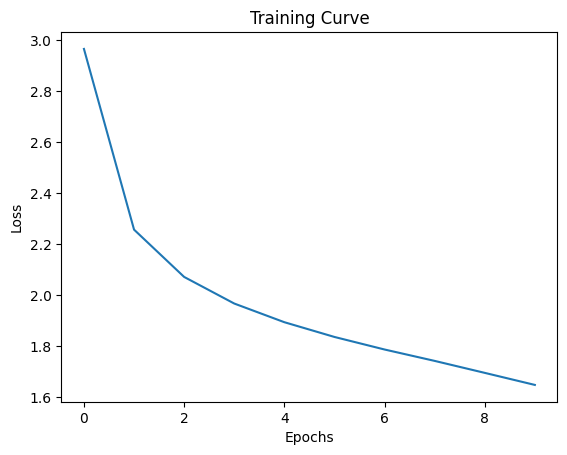

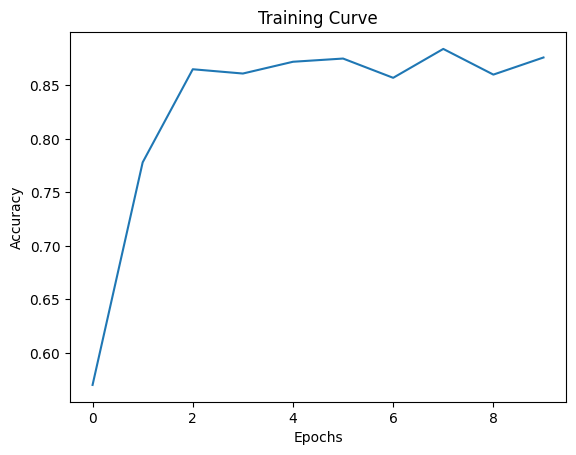

In [ ]:
model2 = TextGenerator(vocab_size, 512)
train(model2,train_data,val_data,batch_size = 10, num_epochs=10, lr=0.001)

0.02639113990086328
[Epoch #0] Loss 3.179979 Accuracy 0.430000
    n ( d = 1 
0.025649545506452067
[Epoch #1] Loss 2.378640 Accuracy 0.750000
    ( t _ { 2 } 
0.027381372839392883
[Epoch #2] Loss 2.162342 Accuracy 0.810000
    7 = 9 
0.023646583798452844
[Epoch #3] Loss 2.049469 Accuracy 0.780000
    \sqrt { \mathrm { ~ f ~ } } 
0.02495861671990975
[Epoch #4] Loss 1.979002 Accuracy 0.890000
    x ^ { 2 } + x ^ { 2 } 
0.022313244245471674
[Epoch #5] Loss 1.924356 Accuracy 0.880000
    \mathrm { ~ i ~ } 
0.02297139415804976
[Epoch #6] Loss 1.871746 Accuracy 0.810000
    p ^ { n } - r ^ { n } - 1 
0.02403409069062018
[Epoch #7] Loss 1.837732 Accuracy 0.860000
    { - \gamma } 
0.022768899760614175
[Epoch #8] Loss 1.804131 Accuracy 0.920000
    x _ { 1 } = x _ { 3 } 
0.02255722336092637
[Epoch #9] Loss 1.780441 Accuracy 0.830000
    a _ { i j } 
Finished Training
Total time elapsed: 231.17 seconds


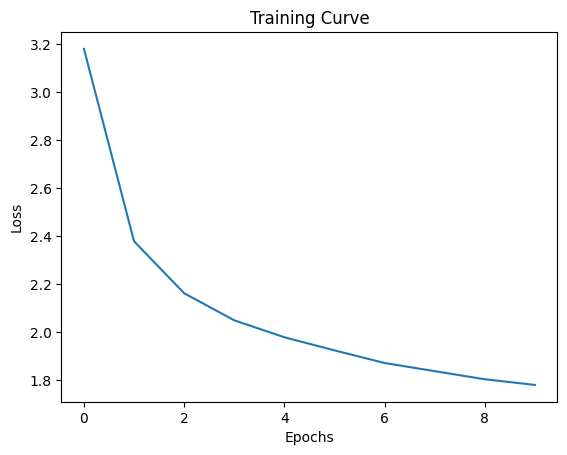

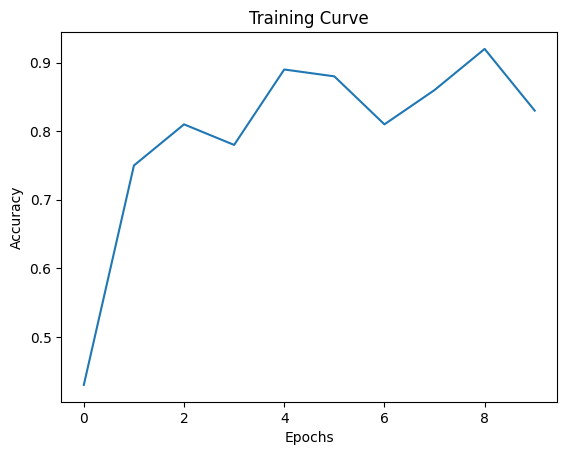

In [ ]:
model2 = TextGenerator(vocab_size, 256)
train(model2,train_data,val_data,batch_size = 10, num_epochs=10, lr=0.001)

0.031563592280758765
[Epoch #0] Loss 3.384447 Accuracy 0.400000
    { X ^ { \mathrm { ~ } ~ } = ^ { 2 } \right) <pad> + { { ~ u ~ } } } 
0.02821755585652322
[Epoch #1] Loss 2.546093 Accuracy 0.630000
    \sqrt { i } } ^ { 2 } = t - { x } } _ { n } + k { c i n 
0.02837656184277204
[Epoch #2] Loss 2.276662 Accuracy 0.710000
    a e ^ { 1 } _ { 2 } 
0.026042067592957435
[Epoch #3] Loss 2.159795 Accuracy 0.720000
    2 
0.027239463017514235
[Epoch #4] Loss 2.084648 Accuracy 0.750000
    q = 0 
0.024539334773863438
[Epoch #5] Loss 2.022792 Accuracy 0.940000
    y = y 
0.02541351138600467
[Epoch #6] Loss 1.976635 Accuracy 0.900000
    \mathrm { ~ E i ~ } 
0.023550327877394403
[Epoch #7] Loss 1.944502 Accuracy 0.810000
    \sum _ { \left[ \mathrm { ~ N ~ } R } ^ { { \mathrm { ~ L ~ } - v } } \mathrm { ~ j ~ } } 
0.0268878571715295
[Epoch #8] Loss 1.908893 Accuracy 0.880000
    n _ { 1 } = a _ { i + i } 
0.022576798815700932
[Epoch #9] Loss 1.879271 Accuracy 0.860000
    \frac { \pi } { 3 } 
F

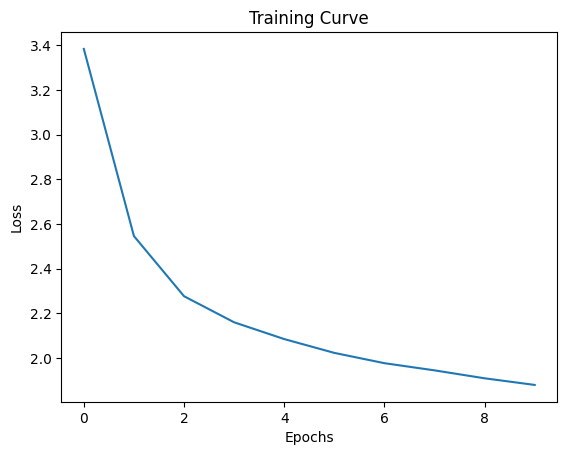

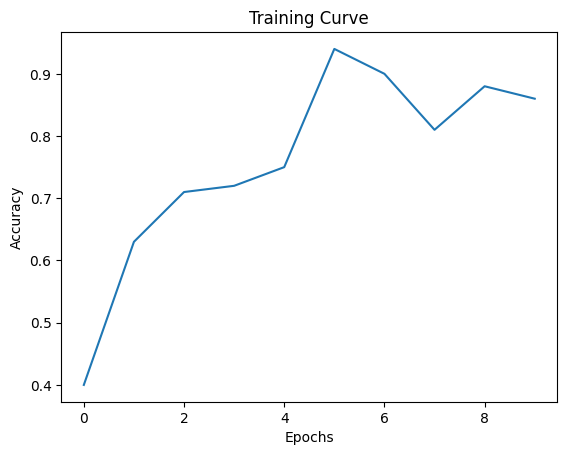

In [ ]:
model3 = TextGenerator(vocab_size, 128)
train(model3,train_data,val_data,batch_size = 10, num_epochs=10, lr=0.001)

In [ ]:
get_val_bleu_tf(model,val_data,0.8)

0.04659069674154679

In [ ]:
print(sample_sequence(model2,"asd"))

asd ^ { 2 } - 1 


In [ ]:
for seq in smart_generator(model2, "\\int" ,min_len = 5,max_len=20, temperature=0.8,num_of_img = 4,must_contain= "y"):
  print(seq)

0.49591064453125
0.10363554954528809
0.5944015979766846
0.0989224910736084
\int c - 6 d y 
\int \left( \mathrm { ~ z ~ } y d \right) 
\int \sqrt { \mathrm { ~ x ~ } } ^ { y } d d 
\int _ { \mathrm { ~ r ~ } } ^ { \mathrm { ~ Y y ~ } } 


In [ ]:
# latex_checker("r = e ^ { k }")
check_latex_syntax("r = e ^ { k }")

True

In [ ]:
# Generate valid LaTeX expressions
print(generate_valid_sequence(model, "r = e ^ 2"))

Long user input!


TypeError: write() argument must be str, not None

In [ ]:
# Generate LaTeX expressions with min length
print(min_max_sequence(model,"x =",))

x = \frac { 2 \pi } { 4 p } d ( n - 1 ) 


In [ ]:
# Generate random LaTeX expressions with diff temperature
print(sample_sequence(model,"x =" ,temperature=0.8))
print(sample_sequence(model,"r =" ,temperature=1.0))
print(sample_sequence(model,"\\int" ,temperature=1.5))
print(sample_sequence(model,"\\frac" ,temperature=2.0))
print(sample_sequence(model,"\\phi" ,temperature=5.0))

x = 1 
r = - \sqrt { L } 
\int \left( w \right) } 
\frac \pm 5 \cdot u \neq 6 3 i ( 7 / B 2 0 ) \div ( 2 \times 5 
\phi \pm [ \cdot N h H \right) M 7 H \right) u \right| y z \theta 5 \forall \sqrt E 
